# Topic Modeling for Covid-19 & China Corpus - AI for People

In this notebook we are going to use a topic modeling strategy called [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). If you want to understand LDA properly we can recommend the following links:
 - [Youtube Explainer](https://www.youtube.com/watch?v=3mHy4OSyRf0)
 - [Tutorial in Python](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)
 - [Intuitive Guide to Latent Dirichlet Allocation](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)
 
This topic modeling will be the standard LDA approach using the Gensim library. Although, there are many other packages available (NLTK, Scikit etc.) we have chosen Gensim here and we provide a bit of an intuition when it comes to a more fine-grained setting of the LDA.

### Statistical Inference (Variational Bayes vs. Gibbs Sampling)
Learning the various distributions in our corpus (the set of topics, their associated word probabilities, the topic of each word) is a problem of statistical inference. There are different ways of doing this statistical inference. The original [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) uses a variational Bayes approximation of the posterior distribution. What is variational Bayes then? As far as we are concerned [variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) are a family of techniques for approximating intractable integrals arising during the training of our LDA model. A different method of doing the statistical inference is [Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling). It [has been argued that Gibbs Sampling is more suitable](http://www.jmlr.org/papers/volume18/16-374/16-374.pdf) for the task of LDA.

Make sure that whatever LDA package you are using, to check what kind of statistical inference is used within its training. For Gensim, we can check the documentation: https://radimrehurek.com/gensim/models/ldamodel.html and realize "The core estimation code is based on the onlineldavb.py script, by Hoffman, Blei, Bach: Online Learning for Latent Dirichlet Allocation, NIPS 2010.", which is using Online Variational Bayes. In order to use Gibbs Sampling instead, we can use the Mallet package that provides a method called LdaMallet - which is using our Gibbs Sampling: https://radimrehurek.com/gensim/models/wrappers/ldamallet.html as it states "This module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents, using an (optimized version of) collapsed gibbs sampling from MALLET."

### Package Environment
This notebook is created using Python 3.6 with a few libraries. Mainly, we are using teh Gensim library (pip install Gensim), the Mallet wrapper (for the Gibbs Sampling) and a few others. Therefore, the next cells contains all the necessary libraries so you can make sure everything is installed on your system. You will need to change your system variables for the mallet environment path. [See how to install mallet here.](https://www.tutorialspoint.com/gensim/gensim_creating_lda_mallet_model.htm)

In [14]:
# importing all libraries
import os
import gensim
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
os.environ['MALLET_HOME'] = 'C:\\Python36-32\\mallet-2.0.8'
mallet_path = 'C:\\Python36-32\\mallet-2.0.8\\bin\\mallet' 

### Loading the corpus
Due to the Twitter restrictions of data sharing, we cannot provide the corpus. What we can provide are the Tweet-IDs from our corpus. Those can be combined with Software such as [Hydrator](https://github.com/DocNow/hydrator) to collect the corpus. We have explained in the [Technical Article II](https://medium.com/ai-for-people/the-rise-of-sinophobia-on-twitter-during-the-covid-19-pandemic-technical-part-2-384917ddd16d) how the subcorpus of tweets containing CHINA or CHINESE has been created. For this notebook it is important to note that the format of each line in the corpus is the following:
`YYYY-MM-DD HH:MM:SS ::: TWEET`
Therefore, we can split the whole line with with spaces and collect only the tweet with indexing [3:]. If the formatting of your own corpus is different, you might need to adjust these.'

In [6]:
# Loading dataset
documents = []
with open("../data/chinese_covid_copus.txt", "r", encoding="utf-8") as f_in:
    # read all lines from one batch
    document = f_in.readlines()
    # connect all lines to one big line per batch
    for tweet in document:
        # split the tweet into separate words
        tweet = tweet.split(" ")
        # get rid of empty entries
        tweet = [word.strip(",").strip("\n").strip(".").lower() for word in tweet if word]
        # append the batch words in the documents list
        tweet = tweet[3:]
        documents.append(tweet)

print("Tweets read: "+str(len(documents)))

Tweets read: 16724


### Pre-Processing 
Next, we will define two functions that will help us with the pre-processing of the data. For the LDA, we need to tokenize all words in our corpus. On Twitter, language has a bit of a different "slang" and hence we want our pre-processing to account for specific Twitter slang. In our first processing part, we are simply loading a list of stopwords. You can simply create a text file and store words in there, which you want to filter out. We have used some list found [here](https://github.com/meetsha/gensim/blob/master/stopwords.txt) and [here](https://gist.github.com/sebleier/554280). Now we define Gensim's simple preprocessing, which lowercases, tokenizes our words. We also don't want to allow tokens smaller than 3 items (e.g. "aa", "fu", "lo" "gg" etc).

In [8]:
# loading the stopwords
with open("../data/stopwords.txt", "r") as f_in:
    stopwords = f_in.readlines()
    stopwords = [word.strip() for word in stopwords]
    stopwords = set(stopwords)

def preprocess(word_list):
    result = []
    text = " ".join(word_list)
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopwords:
            result.append(token)
    return result

### Tweet Tokenization
We are also using the NLTK package now, because it contains a tokenizer that can handle tweets more appropriately. Meaning, it has more-fine grained tokenization for Twitter slang. [Find out more in the documentation of its source code](https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer).

In [11]:
# Tokenization 
print("Tweet tokenization...")
tweet_tokenizer = TweetTokenizer()
tweet_token_docs = []
for idx, document in enumerate(documents):
    document = " ".join(document)
    tweet_token_docs.append(tweet_tokenizer.tokenize(document))
print("... finished.")

Tweet tokenization...
... finished.
16724


### Creating a Bag-of-Words and Dictionary
We now have to transform our tokens into bag of words in order to use the Gensim LDA. For a more detailed and general explanation of this, [see here](https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm). 

In [12]:
print("Preprocessing...")
processed_docs = [preprocess(elem) for elem in tweet_token_docs]
dictionary = gensim.corpora.Dictionary(processed_docs)
del_ids = [k for k,v in dictionary.items() if v=='https']
dictionary.filter_tokens(bad_ids=del_ids)
print("... finished.")
# turn documents in bags of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Preprocessing...
... finished.


### Term frequency–inverse document frequency (tf-idf)
Now, we can do some additional frequency adjustment to weight the most important words in each tweet. For example, if a word like "flowerpot" happens to exist in EVERY tweet, it is not very informative. If it only appear a lot, but in very few tweets, there is a different frequency with respect to the document frequency. Long story short, we use one of the most popular term-weighting schemes to balance the word frequencies:
[Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf): The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.

*Note: Our tweets are the documents.*

In [13]:
# do tfidf
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

print("Number of tokens: "+str(len(bow_corpus)))

Number of tokens: 16724


### Training the LDA model (using Gibbs Sampling)
We can now train our LDA model provided the bag-of-words and dictionary of tf-idf-terms we have created. Topic Modeling algorithms are trying to find topics within a given corpora. Naturally, a corpus of text does not have a pre-defined set of N topics. Therefore, we need to decide how many topics we want the LDA model to form/find within our corpus. It is a good idea to start with 1 topic and work our way up to 16 topics. In the next cell, we are running 16 trainings with an increaing topic size and store each model in `mallet_models`. Additionally, after every model is created we assess it's coherence value. [Here](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/) is an article that explains this a bit more. In very short, our coherence value is a measure of the statistical coherence within the topics. Or to put it in practical terms: the better our coherence score for a given topic size, the better. Note: there are diffenent coherence measures and we have chosen the $C_v$ measure. It is not as fast as $C_{Mass}$, but considered more thorough. We store the evaluation of the $C_V$ in a list for all 16 topic sizes.

In [15]:

mallet_models_coherence_cV = []
mallet_models = dict()

for num_topics in range(1, 17):
    print("Type: Mallet | Topics: "+str(num_topics))
    model_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, 
                                             num_topics=num_topics,id2word=dictionary, workers=4)
    
    coherencemodel = CoherenceModel(model=model_mallet, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_value = coherencemodel.get_coherence()
    mallet_models_coherence_cV.append(coherence_value)
    
    mallet_models[num_topics] = model_mallet
    

Type: Mallet | Topics: 1
Type: Mallet | Topics: 2
Type: Mallet | Topics: 3


c:\python36-32\lib\site-packages\gensim\models\wrappers\ldamallet.py:380: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


Type: Mallet | Topics: 4
Type: Mallet | Topics: 5
Type: Mallet | Topics: 6
Type: Mallet | Topics: 7
Type: Mallet | Topics: 8
Type: Mallet | Topics: 9
Type: Mallet | Topics: 10
Type: Mallet | Topics: 11
Type: Mallet | Topics: 12
Type: Mallet | Topics: 13
Type: Mallet | Topics: 14
Type: Mallet | Topics: 15
Type: Mallet | Topics: 16


### Visualizing the Coherence
After training we can now plot the coherence for each topic size in order to identify the best topic size for further analysis. For this, we can use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_\(clustering\)). 

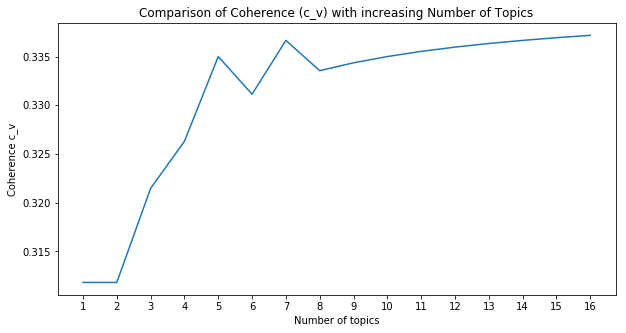

In [19]:
fig = plt.figure(figsize=[10,5])
ax = plt.axes()

ax.plot(range(1, len(mallet_models)+1),  mallet_models_coherence_cV)
plt.title("Comparison of Coherence (c_v) with increasing Number of Topics")
plt.xlabel("Number of topics")
plt.ylabel("Coherence c_v")
plt.xticks(range(1,17))
plt.show()

print()